In [364]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms
import itertools
import importlib
import time

In [365]:
from training import toy
importlib.reload(toy)
torch.manual_seed(42)

batch_size = 2

trainset = toy.TwoMoonsDataset(samples=100, noise=0.1, seed=42)
trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True)

testset = toy.TwoMoonsDataset(samples=100, noise=0.1, seed=42, extra_samples=100)

device = torch.device("cpu")

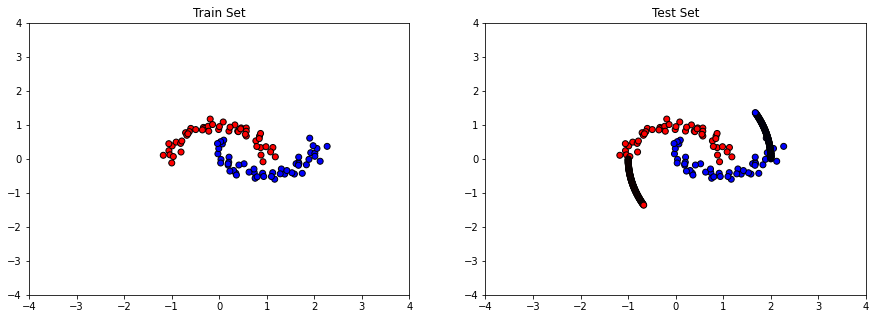

In [366]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

eval_points = 100
sample_cmap = ListedColormap(["red", "blue"])
area_cmap = plt.cm.RdBu
variance_cmap = plt.cm.viridis
xlim = 4
ylim = 4

def plot_samples(ax, dataset):
    data, labels = zip(*dataset)
    ax.scatter(*zip(*data), c=labels, cmap=sample_cmap, edgecolors="black")

def plot(name, eval, samples):
    with torch.no_grad():
        fig, ((value_ax, var_ax), (rel_ax, _)) = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(name)
        value_ax.set_xlim(-xlim, xlim)
        value_ax.set_ylim(-ylim, ylim)
        var_ax.set_xlim(-xlim, xlim)
        var_ax.set_ylim(-ylim, ylim)
        
        # Grid evaluation
        xs, ys = np.meshgrid(np.linspace(-xlim, xlim, eval_points), np.linspace(-ylim, ylim, eval_points))
        data = np.dstack((xs.reshape(eval_points * eval_points), ys.reshape(eval_points * eval_points)))[0]
        results = torch.stack(eval(torch.from_numpy(data).float(), samples)).reshape((samples, eval_points, eval_points))
        value_ax.contourf(xs, ys, results.mean(dim=0), 100, cmap=area_cmap)
        var_ax.contourf(xs, ys, results.var(dim=0), 100, cmap=variance_cmap, vmin=0, vmax=1.0)

        # Training samples
        results = torch.stack(eval(testset.samples, samples))
        predictions = torch.round(torch.round(results).mean(dim=0))
        confidences = (2 * torch.abs(results - 0.5)).mean(dim=0)
        errors = predictions == testset.labels
        value_ax.scatter(*zip(*testset.samples), facecolors=sample_cmap(predictions), edgecolors=sample_cmap(testset.labels))

        # Reliability diagram
        bin_count = 10
        bins = [[] for _ in range(bin_count)]
        for i, confidence in enumerate(confidences):
            bins[torch.floor(confidence * bin_count).int()].append(i)
        bin_accuracys = np.array([errors[bin].sum() / len(bin) if len(bin) > 0 else 0 for bin in bins])
        mid = np.linspace(0, 1 - 1 / bin_count, bin_count)
        bin_errors = np.abs(np.array(bin_accuracys) - mid)
        bin_confidences = np.array([confidences[bin].sum() / len(bin) if len(bin) > 0 else 0 for bin in bins])

        rel_ax.set_xlim(0, 1)
        rel_ax.set_ylim(0, 1)
        rel_ax.grid(color="tab:grey", linestyle=(0, (1, 5)), linewidth=1)
        interval = np.arange(0, 1, 1 / bin_count)
        rel_ax.bar(interval, bin_accuracys, 1 / bin_count, align="edge", color="b", edgecolor="k")
        rel_ax.bar(interval, bin_errors, 1 / bin_count, bottom=np.minimum(bin_accuracys, mid), align="edge", color="mistyrose", alpha=0.5, edgecolor="r", hatch="/")
        rel_ax.set_ylabel('Accuracy',fontsize=16)
        rel_ax.set_xlabel('Confidence',fontsize=16)

        ece = np.mean(np.abs(bin_accuracys - bin_confidences))
        mce = np.max(np.abs(bin_accuracys - bin_confidences))

        ident = [0.0, 1.0]
        rel_ax.plot(ident,ident,linestyle='--',color="tab:grey")

        text = f"{samples} weight sample(s)\n" \
            + f"Accuracy (majority vote): {errors.sum() / (len(testset.samples))} \n" \
            + f"ECE: {ece} \n" \
            + f"MCE: {mce}"
        fig.text(0.5, 0.01, text, ha="center", va="top", fontsize=12)

fig, (train_fig, test_fig) = plt.subplots(1, 2, figsize=(15, 5))
train_fig.set_title("Train Set")
train_fig.set_xlim(-xlim, xlim)
train_fig.set_ylim(-ylim, ylim)
test_fig.set_title("Test Set")
test_fig.set_xlim(-xlim, xlim)
test_fig.set_ylim(-ylim, ylim)
plot_samples(train_fig, trainset)
plot_samples(test_fig, testset)

C:\Users\flose\.conda\envs\ml\lib\site-packages\matplotlib\contour.py:1486: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
C:\Users\flose\.conda\envs\ml\lib\site-packages\matplotlib\contour.py:1487: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


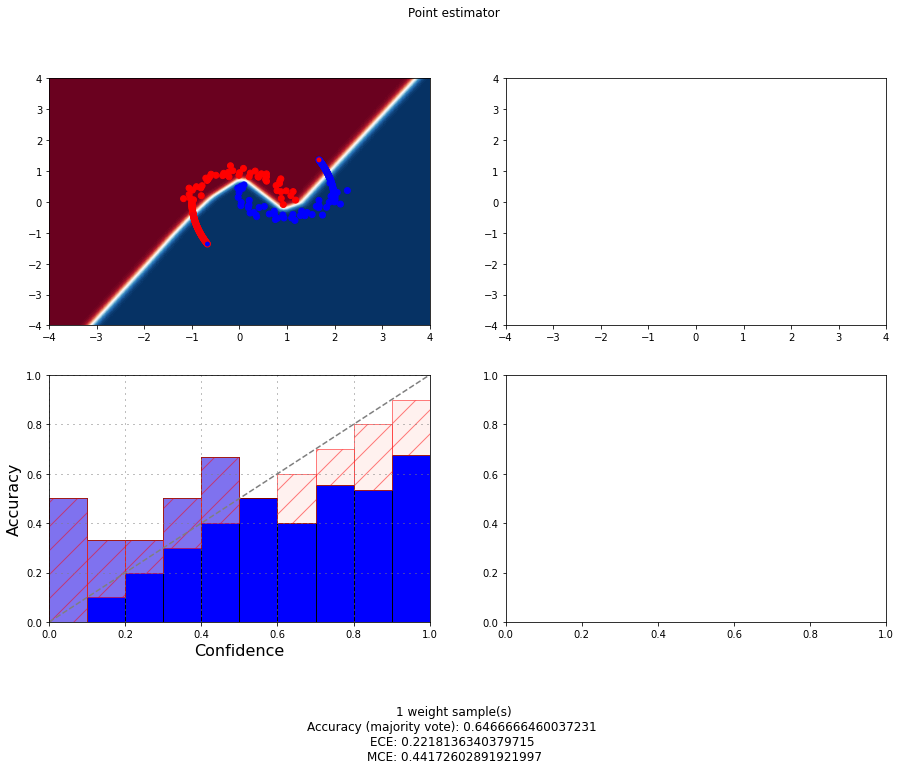

In [357]:
def eval_pp(input, samples):
    return [pp_model(input) for _ in range(samples)]

plot("Point estimator", eval_pp, 1)

In [363]:
# Point estimator with L2 regularization

torch.manual_seed(42)

pp_model = nn.Sequential(
    nn.Linear(2, 16), 
    nn.ReLU(), 
    nn.Linear(16, 16),
    nn.ReLU(), 
    nn.Linear(16, 1),
    nn.Sigmoid()
)

optimizer = torch.optim.SGD(pp_model.parameters(), lr=0.01)
for epoch in range(500):
    epoch_loss = torch.tensor(0, dtype=torch.float)
    for data, target in trainloader:
        optimizer.zero_grad()
        output = pp_model(data)
        loss = F.binary_cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: loss {epoch_loss / (len(trainloader) * batch_size)}")
print(f"Final loss {epoch_loss / (len(trainloader) * batch_size)}")

def eval_pp(input, samples):
    return [pp_model(input) for _ in range(samples)]

plot("Point estimator", eval_pp, 1)

ValueError: Unknown activation function sigmoid

Epoch 0: loss 0.34105873107910156
Epoch 100: loss 0.11513890326023102
Epoch 200: loss 0.031730446964502335
Epoch 300: loss 0.006549667101353407
Epoch 400: loss 0.0031353188678622246
Final loss 0.0019298300612717867


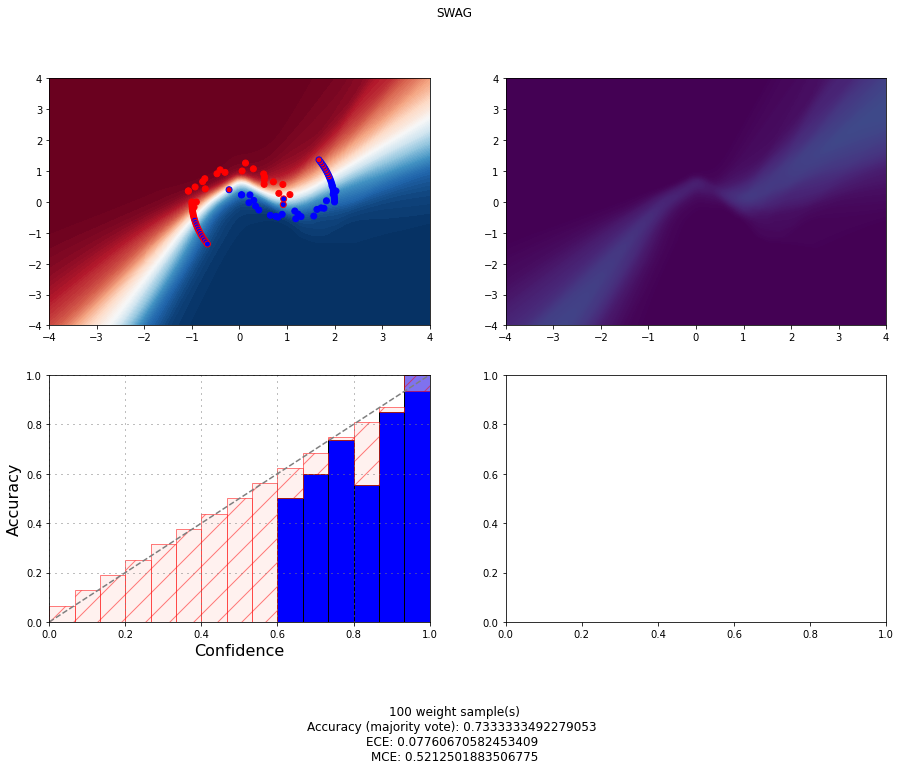

In [342]:
# SWAG trained with SGD and L2 regularization (lr is currently not adjusted for SWAG)

from training import swag
importlib.reload(swag)

torch.manual_seed(42)

swag_model = nn.Sequential(
    nn.Linear(2, 16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, 1),
    nn.Sigmoid()
)

optimizer = torch.optim.SGD(swag_model.parameters(), lr=0.01) # Without weight_decay the covariance matrix is not positive definit???
wrapper = swag.SWAGWrapper(swag_model, 5, 10)
for epoch in range(500):
    epoch_loss = torch.tensor(0, dtype=torch.float)
    for data, target in trainloader:
        optimizer.zero_grad()
        output = swag_model(data)
        loss = F.binary_cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss
    wrapper.update(epoch)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: loss {epoch_loss / (len(trainloader) * batch_size)}")
print(f"Final loss {epoch_loss / (len(trainloader) * batch_size)}")

def eval_swag(input, samples):
    torch.manual_seed(42)
    return [wrapper.sample(swag_model, input) for _ in range(samples)]
plot("SWAG", eval_swag, 100)

Training model 0
  Epoch 0: loss 0.34109610319137573
  Epoch 100: loss 0.11664227396249771
  Epoch 200: loss 0.032856784760951996
  Epoch 300: loss 0.006627893075346947
  Epoch 400: loss 0.003141877707093954
  Final loss 0.0019453911809250712
Training model 1
  Epoch 0: loss 0.3541962504386902
  Epoch 100: loss 0.10988371819257736
  Epoch 200: loss 0.026331493631005287
  Epoch 300: loss 0.007978638634085655
  Epoch 400: loss 0.0036698526237159967
  Final loss 0.0022545347455888987
Training model 2
  Epoch 0: loss 0.3395068049430847
  Epoch 100: loss 0.071039117872715
  Epoch 200: loss 0.011864551343023777
  Epoch 300: loss 0.00451844884082675
  Epoch 400: loss 0.002519159112125635
  Final loss 0.001682711998000741
Training model 3
  Epoch 0: loss 0.33683228492736816
  Epoch 100: loss 0.10306539386510849
  Epoch 200: loss 0.019750917330384254
  Epoch 300: loss 0.007218695245683193
  Epoch 400: loss 0.003698815358802676
  Final loss 0.0023895874619483948
Training model 4
  Epoch 0: loss 

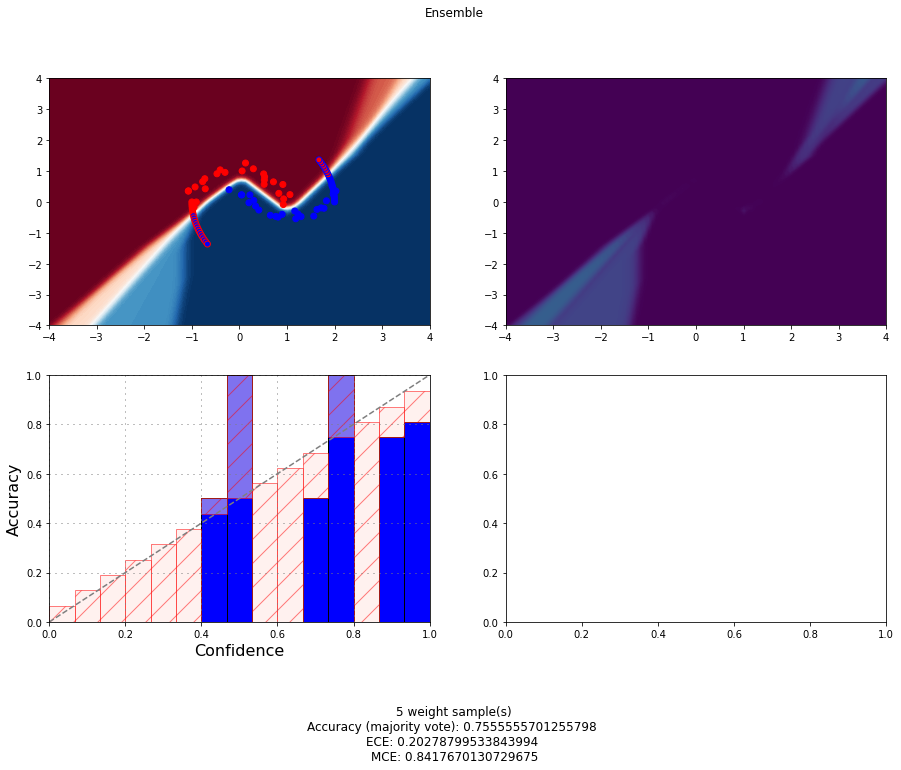

In [343]:
# Ensemble of point estimators with L2 regularization

from training import ensemble
importlib.reload(ensemble)

torch.manual_seed(42)

ensemble_count = 5
models = [nn.Sequential(
    nn.Linear(2, 16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, 1),
    nn.Sigmoid()
) for _ in range(ensemble_count)]

for i, model in enumerate(models):
    print(f"Training model {i}")
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    for epoch in range(500):
        epoch_loss = torch.tensor(0, dtype=torch.float)
        for data, target in trainloader:
            optimizer.zero_grad()
            output = model(data)
            loss = F.binary_cross_entropy(output, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss
        if epoch % 100 == 0:
            print(f"  Epoch {epoch}: loss {epoch_loss / (len(trainloader) * batch_size)}")
    print(f"  Final loss {epoch_loss / (len(trainloader) * batch_size)}")


def eval_esemble(input, samples):
    assert samples == len(models)
    return [model(input) for model in models]
plot("Ensemble", eval_esemble, ensemble_count)

Epoch 0: loss 8.858044624328613
Epoch 10: loss 8.534250259399414
Epoch 20: loss 8.20796012878418
Epoch 30: loss 7.86453104019165
Epoch 40: loss 7.481273174285889
Epoch 50: loss 7.139747142791748
Epoch 60: loss 6.823400974273682
Epoch 70: loss 6.518066883087158
Epoch 80: loss 6.217681884765625
Epoch 90: loss 5.921053886413574
Epoch 100: loss 5.6357245445251465
Epoch 110: loss 5.346407413482666
Epoch 120: loss 5.071924209594727
Epoch 130: loss 4.787854194641113
Epoch 140: loss 4.509966850280762
Epoch 150: loss 4.267373085021973
Epoch 160: loss 3.9953396320343018
Epoch 170: loss 3.741835117340088
Epoch 180: loss 3.5004067420959473
Epoch 190: loss 3.2842679023742676
Epoch 200: loss 3.0317907333374023
Epoch 210: loss 2.835439443588257
Epoch 220: loss 2.6359853744506836
Epoch 230: loss 2.4525301456451416
Epoch 240: loss 2.2451953887939453
Epoch 250: loss 2.0866756439208984
Epoch 260: loss 1.9316339492797852
Epoch 270: loss 1.7612932920455933
Epoch 280: loss 1.6157379150390625
Epoch 290: loss

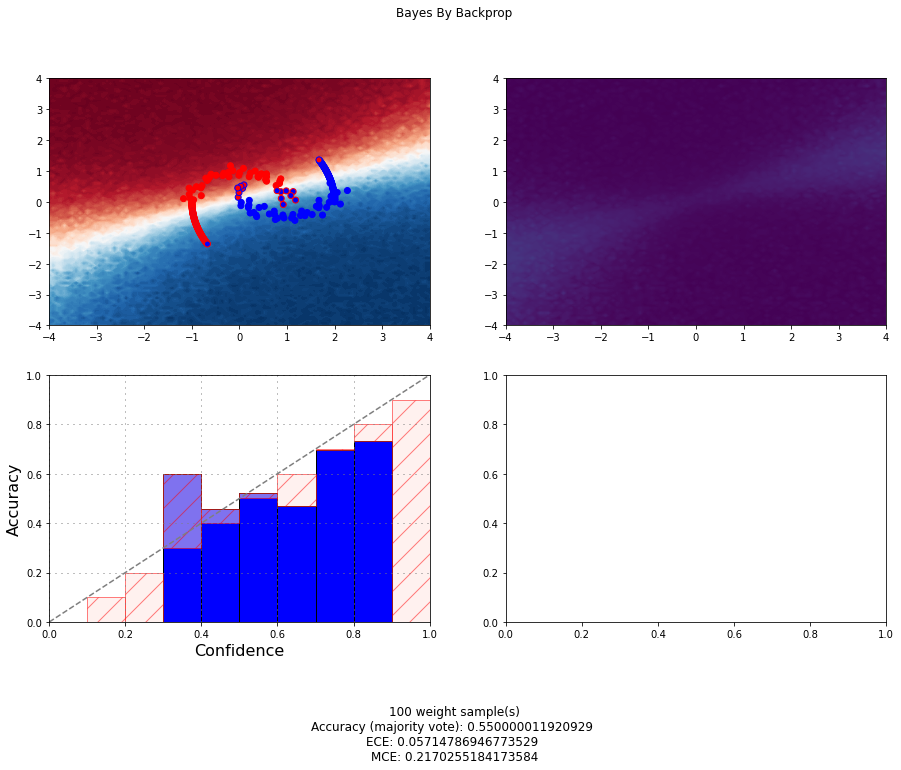

In [358]:
# Bayesian NN (Bayes-by-Backprop)

from training import bbb, util
importlib.reload(bbb)
importlib.reload(util)

torch.manual_seed(42)

prior = bbb.GaussianPrior(0, 1)
#prior = bbb.MixturePrior(0.25, torch.exp(torch.tensor(-0)), torch.exp(torch.tensor(-6)))

model = nn.Sequential(
    bbb.BBBLinear(2, 16, prior, prior, device, mc_sample=5),
    nn.ReLU(),
    bbb.BBBLinear(16, 16, prior, prior, device, mc_sample=5),
    nn.ReLU(),
    bbb.BBBLinear(16, 1, prior, prior, device, mc_sample=5),
    nn.Sigmoid()
)

model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = torch.nn.BCELoss()

for epoch in range(500):
    loss = bbb.run_bbb_epoch(model, optimizer, loss_fn, trainloader, device)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: loss {loss / (len(trainloader) * batch_size)}")
print(f"Final loss {loss / (len(trainloader) * batch_size)}")


def eval_bbb(input, samples):
    return [model(input) for _ in range(samples)]
plot("Bayes By Backprop", eval_bbb, 100)

Epoch 0: loss 0.34144553542137146
Epoch 100: loss 0.1236695647239685
Epoch 200: loss 0.12215214967727661
Epoch 300: loss 0.026468666270375252
Epoch 400: loss 0.028767388314008713
Final loss 0.03276137262582779


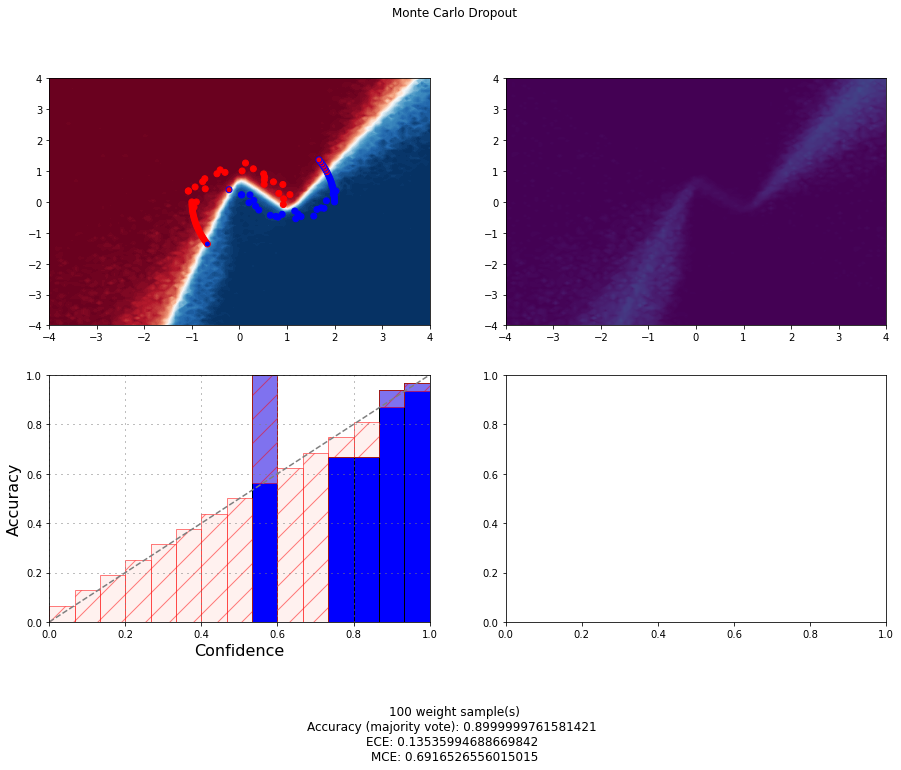

In [345]:
# MC dropout

torch.manual_seed(42)

p = 0.1

model = nn.Sequential(
    # It seems to be counterproductive to drop inputs because there are only 2 inputs
    nn.Linear(2, 16),
    nn.ReLU(),
    nn.Dropout(p),
    nn.Linear(16, 16), 
    nn.ReLU(), 
    nn.Dropout(p),
    nn.Linear(16, 1),
    nn.Sigmoid()
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
for epoch in range(500):
    model.train()
    epoch_loss = torch.tensor(0, dtype=torch.float)
    for data, target in trainloader:
        optimizer.zero_grad()
        output = model(data)
        loss = F.binary_cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: loss {epoch_loss / (len(trainloader) * batch_size)}")
print(f"Final loss {epoch_loss / (len(trainloader) * batch_size)}")

def eval_dropout(input, samples):
    model.train() # Enable dropout
    return [model(input) for _ in range(samples)]

plot("Monte Carlo Dropout", eval_dropout, 100)

Epoch 0: loss 3.7850186824798584
Epoch 100: loss 0.4650314450263977
Epoch 200: loss 0.38969218730926514
Epoch 300: loss 0.4428802728652954
Epoch 400: loss 0.38490164279937744
Final loss 0.42712631821632385


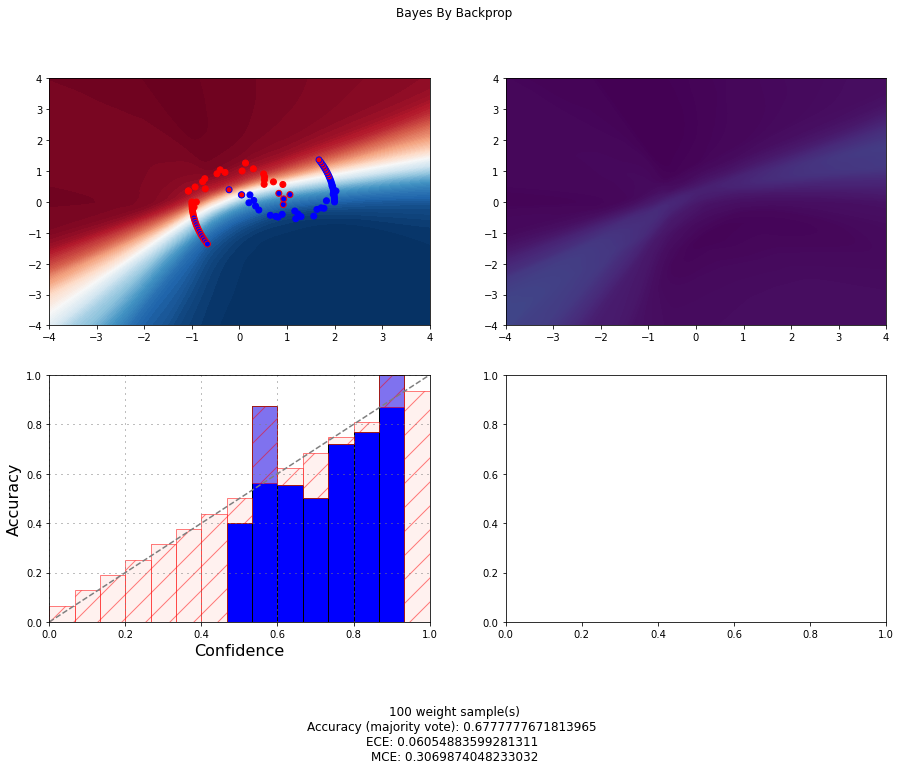

In [347]:
from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn, get_kl_loss

torch.manual_seed(42)

const_bnn_prior_parameters = {
        "prior_mu": 0.0,
        "prior_sigma": 1.0,
        "posterior_mu_init": 0.0,
        "posterior_rho_init": -3.0,
        "type": "Reparameterization",
        "moped_enable": False,
        "moped_delta": 0.5,
}

model = nn.Sequential(
    nn.Linear(2, 16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, 1),
    nn.Sigmoid()
)

dnn_to_bnn(model, const_bnn_prior_parameters)

optimizer = torch.optim.Adam(model.parameters(), 0.01)
for epoch in range(500):
    model.train()
    epoch_loss = torch.tensor(0, dtype=torch.float)
    for data, target in trainloader:
        optimizer.zero_grad()
        output = model(data)
        loss = get_kl_loss(model) / batch_size + F.binary_cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: loss {epoch_loss / (len(trainloader) * batch_size)}")
print(f"Final loss {epoch_loss / (len(trainloader) * batch_size)}")

def eval_bayes(input, samples):
    model.eval()
    return [model(input) for _ in range(samples)]
plot("Bayes By Backprop", eval_bayes, 100)